# Chapter 1: Supervised vs Unsupervised

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import manifold #this is for t-SNE

%matplotlib inline

In [3]:
#get the playground dataset from sklearn, convert target to str. features are 784 pixel points for 70k images
data = datasets.fetch_openml('mnist_784',
                            version=1,
                            return_X_y=True)
pixel_values,targets = data
targets=targets.astype(int)

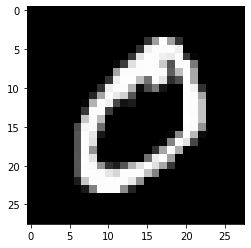

In [25]:
#visualize the samples - by reshaping and using plt

single_image = pixel_values[1,:].reshape(28,28)
plt.imshow(single_image,cmap='gray')

In [28]:
#create a t-SNE transformation of the data
  # 2 components allows to visualize in 2 dim setting easily, first 3k examples
    #creates an array of 3000 rows and 2 columns
tsne=manifold.TSNE(n_components=2,random_state=42)

transformed_data = tsne.fit_transform(pixel_values[:3000,:])

In [45]:
#convert to pd dataframe (stack columns next to one another [concat would be used if they were dfs/series])
tsne_df = pd.DataFrame(
    np.column_stack((transformed_data,targets[:3000])),
    columns=['x','y','targets'])

tsne_df.loc[:,'targets'] = tsne_df.targets.astype(int)

In [46]:
#represents tsne components and targets 
tsne_df

,x,y,targets
0,-5.281551,-28.952768,5
1,-26.105896,-68.069321,0
2,-42.503582,35.580391,4
3,38.893967,26.663395,1
4,-14.770573,35.433247,9
...,...,...,...
2995,9.038110,58.850792,7
2996,-29.405334,-60.951775,0
2997,13.466378,47.369007,9
2998,-2.435752,7.983772,1


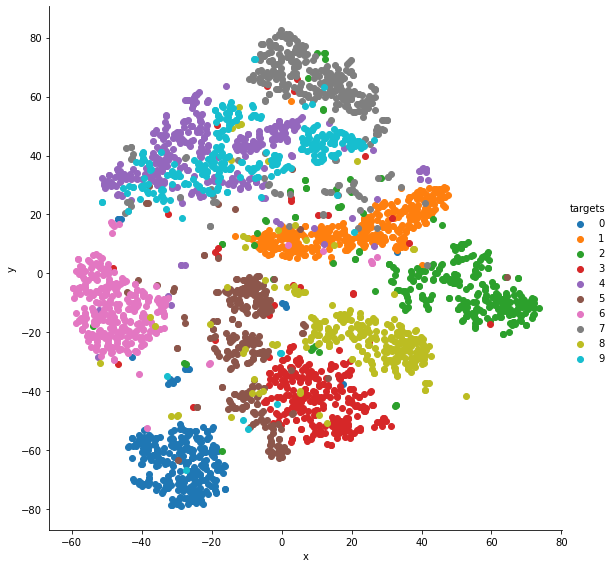

In [52]:
# plot using seaborn / plt

grid=sns.FacetGrid(tsne_df,hue='targets',height=8)

grid.map(plt.scatter,'x','y').add_legend()

# Chapter 2: Cross Validation (and overfitting)

##### cross-validation is a step in the process of building a machine learning model which helps us ensure that our models fit the data accurately and also ensures that we do not overfit.

In [2]:
import pandas as pd

#   dataset from here: 
#     https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

df=pd.read_csv('Downloads/winequality-red.csv',sep=';')

In [3]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
#map quality to more understandable 0-5
quality_mapping={
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

#use the map function of pandas w any dict to convert the values in a given column to values in dict
df.loc[:,'quality']=df['quality'].map(quality_mapping)

<AxesSubplot:>

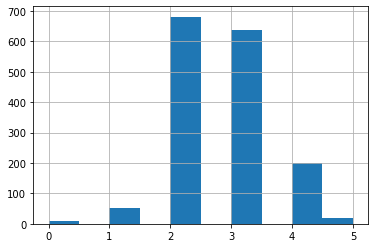

In [5]:
df['quality'].hist()

In [10]:
# we use sample w/ frac=1 to shuffle the dataframe, and reset indices that change after
df = df.sample(frac=1).reset_index(drop=True)

#simple split of train/test set (not the advised way)
df_train = df.head(1000)
df_test=df.tail(599)

In [11]:
# train a decision tree model 

from sklearn import tree
from sklearn import metrics

#init tree classifier & train

clf = tree.DecisionTreeClassifier(max_depth=3)

cols = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide',
       'total sulfur dioxide','density','pH','sulphates','alcohol']

clf.fit(df_train[cols],df_train['quality'])

DecisionTreeClassifier(max_depth=3)

In [15]:
# test the accuracy of this model
train_predictions = clf.predict(df_train[cols])
test_predictions = clf.predict(df_test[cols])

#60% and 54% accuracy roughly.
# if we increase max depth, we get better train results but the test results stay about the same or get worse -- i.e. overfit
train_accuracy = metrics.accuracy_score(df_train.quality,train_predictions)
test_accuracy = metrics.accuracy_score(df_test.quality,test_predictions)

In [18]:
#lets plot at different max depths

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#global size of label text
matplotlib.rc('xtick',labelsize=20)
matplotlib.rc('ytick',labelsize=20)

#this line ensures the plot is displayed inside notebook
%matplotlib inline

#init lists to store accuracies
train_accuracies = [0.5]
test_accuracies = [0.5]

#iterate over depth values
for depth in range(1,25):
    
    clf=tree.DecisionTreeClassifier(max_depth=depth)
    
    clf.fit(df_train[cols],df_train.quality)
    
    train_predictions = clf.predict(df_train[cols])
    test_predictions  = clf.predict(df_test[cols])
    
    train_accuracy = metrics.accuracy_score(df_train.quality,train_predictions)
    test_accuracy = metrics.accuracy_score(df_test.quality,test_predictions)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

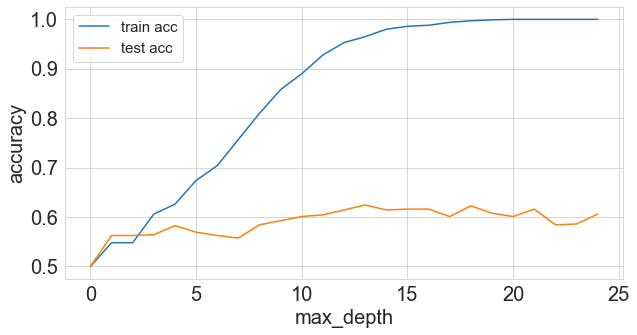

In [24]:
#plot that shows overfitting w/ increasing decision tree depths


plt.figure(figsize=(10,5))
sns.set_style('whitegrid')

plt.plot(train_accuracies,label='train acc')
plt.plot(test_accuracies,label='test acc')

plt.legend(loc='upper left',prop={'size':15})

plt.xticks(range(0,26,5))
plt.xlabel('max_depth',size=20)
plt.ylabel('accuracy',size=20)

plt.show()

### K-Fold Cross Validation

In [28]:
import pandas as pd
from sklearn import model_selection

df=pd.read_csv('Downloads/winequality-red.csv',sep=';')
df['kfold'] = -1

df = df.sample(frac=1).reset_index(drop=True)

kf=model_selection.KFold(n_splits=5)

#fill the new kfold columns
for fold,(trn_,val_) in enumerate(kf.split(X=df)):
    df.loc[val_,'kfold'] = fold


### STRATIFIED K-Fold Cross Validation (a better approach for imbalance)

In [30]:
import pandas as pd
from sklearn import model_selection

df=pd.read_csv('Downloads/winequality-red.csv',sep=';')
df['kfold'] = -1

df = df.sample(frac=1).reset_index(drop=True)

y = df.quality

kf=model_selection.StratifiedKFold(n_splits=5)

#fill the new kfold columns
for fold,(trn_,val_) in enumerate(kf.split(X=df,y=y)):
    df.loc[val_,'kfold'] = fold

<AxesSubplot:>

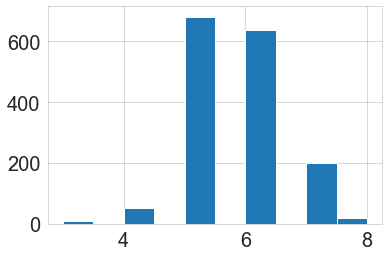

In [34]:
#the wine data set is a good example of a skewed target distribution 
    # we have a a lot of samples and some dont have many labels -- if we do simple k fold, we dont have an equal dist of targets
    # in each fold -- thus we choose stratified k fold
df.quality.hist()

### Stratified K fold for Regression 

In [29]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import model_selection

def create_folds(data):
    
    #create placeholder column
    data['kfold'] = -1
    
    data = data.sample(frac=1).reset_index(drop=True)
    
    #calc number of bins via Sturge Rule
    #take the floor of value, you can also just round it
    num_bins = int(np.floor(1+ np.log2(len(data))))
    
    #bin targets
    data.loc[:,'bins'] = pd.cut(data['target'],bins=num_bins,labels=False)
    
    #init k folds 
    kf = model_selection.StratifiedKFold(n_splits=5)
    
    for f,(t,v) in enumerate(kf.split(X=data,y=data['bins'].values)):
        data.loc[v,'kfold']=f
    
    #drop bins column
    data=data.drop('bins',axis=1)
    
    return data

if __name__ == "__main__":
    #we create a sample dataset w/ 15000 samples and 100 features
         # interesting way to create dataset from sklearn.datasets below
    X,y, = datasets.make_regression(
        n_samples=15000,n_features=100,n_targets=1)
    
    #create df from the np arrays
    df = pd.DataFrame(X,
                     columns=[f"f_{i}" for i in range(X.shape[1])]
                     )
    df.loc[:,'target']=y
    
    #create folds
    df = create_folds(df)

# Chapter 3: Evaluation Metrics

### Knowing when to use which metric is important -- usually more about the targets and less about the data

#### accuracy: only suitable metrics to use when we have an equal number of positive & negative samples in binary classification problem

In [46]:
#accuracy
from sklearn import metrics

l1=[0,1,1,1,0,0,0,1]
l2=[0,1,0,1,0,1,0,0]

metrics.accuracy_score(l1,l2)


# a pythonic way to calculate accuracy
def acc(ytrue,ypred):
    """
    fxn to calculate accuracy
    """
    
    #init simple counter
    counter=0
    
    #loop over elemeents of true and pred together
    for yt,yp in zip(ytrue,ypred):
        if yt==yp:
            counter+=1
    
    return counter / len(ytrue)

#### Precision: TP / (TP + FP)------------------------------
  ##### How often is our model correct when trying to identify positive samples
    
#### Recall: TP / (TP + FN)----------------------------------
   ##### how many positive samples were correctly identified?
   ##### AKA True Positive Rate AKA Sensitivity

#### F1: 2TP / (2TP + FP + FN)-----------------------------
   ##### weighted avg of precision and recall
   
#### FPR: FP / (TN + FP)--------------------------------
   ##### weighted avg of precision and recall
   ##### AKA Specificity 

##  ROC AUC Curve (TPR / FPR curve)
### adept at handling skewed distributions for classifications problems 
##### what does the AUC value mean? with the .83 AUC below, it means that if you select a random positive example, you have a probability of 0.83 to rank the example higher than a negative example ( also known as C-index or Concordance Index)

In [48]:
from sklearn import metrics

y_true = [0, 0, 0, 0, 1, 0, 1,0, 0, 1, 0, 1, 0, 0, 1]
y_pred = [0.1, 0.3, 0.2, 0.6, 0.8, 0.05,0.9, 0.5, 0.3, 0.66, 0.3, 0.2,0.85, 0.15, 0.99]


metrics.roc_auc_score(y_true,y_pred)

0.8300000000000001

##  Log Loss
#### Log Loss = -1 * (target * log(prediction) + (1-target) * log(1-prediction))
##### for many samples, log-loss over all samples is the avg of all individual log losses. 
##### log loss penalizes quite high for far off probabiltiy prediction (punish for being confidently incorrect).... it also punishes more than other metrics b/c it references the probability, instead of the result (i.e. 0.51 vs positive prediction)
##### finally, not easy to interpret, but lower log loss is better for any given problem

In [50]:
from sklearn import metrics
metrics.log_loss(y_true,y_pred)

0.49882711861432294

### Confusion Matrix (seaborn)

Text(0.5, -3.5, 'Predicted Labels')

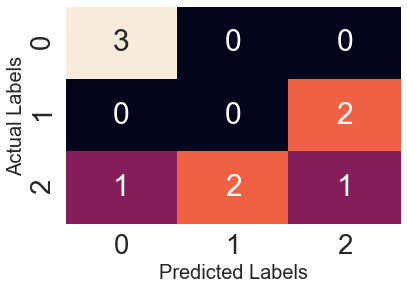

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

y_true = [0, 1, 2, 0, 1, 2, 0, 2, 2]
y_pred = [0, 2, 1, 0, 2, 1, 0, 0, 2]

cm = metrics.confusion_matrix(y_true,y_pred)

#plt.figure(figsize=(10,10))
sns.set(font_scale=2.5)
sns.heatmap(cm,annot=True,cbar=False)

plt.ylabel('Actual Labels', fontsize=20)
plt.xlabel('Predicted Labels', fontsize=20)

## Regression Metrics

In [7]:
# MAE

import numpy as np

def mae(yt,yp):
    error=[]
    for y,p in zip(yt,yp):
        error.append(np.abs(y-p))
    return sum(error)/len(yt)

In [21]:
# MSE
# MSE and RMSE are the most popular metrics used in eval of regression models
def mse(yt,yp):
    error=0
    for y,p in zip(yt,yp):
        error += (y-p)^2
    return error / len(yt)

def rmse(yt,yp):
    error=0
    for y,p in zip(yt,yp):
        error += (y-p)^2
    return np.sqrt(error / len(yt))

In [27]:
# R2 -  Coefficient of Determination
# put simply, how good your model fits the data (how much variation is explained by your model)
 #   1 - unexplained variation / total variation
def r2(yt,yp):
    
    mean_true_value = np.mean(yt)
    
    numerator = 0
    denominator = 0
    
    for y,p in zip(yt,yp):
        
        numerator += (y-p)**2
        
        denominator += (y - mean_true_value)**2
    
    ratio = numerator/denominator
    
    return 1 - ratio

In [29]:
# Matthew's Correlation Coefficient (MCC)
# range -1 to 1, takes into account TP, FP, TN, FN -- so can be used for skewed classes.

# MCC = (TP*TN - FP*FN) / [ (TP+FP)*(FN+TN)*(FP+TN)*(TP+FN) ]** 0.5

# Chapter 4: Arranging ML Projects

In [13]:
# arrange project folder : [input, src (scripts), models, notebooks, readme, license]
# first step when approaching ML project, decide the evaluation metric 

# example: create py scripts for model training

#config.py---------------------------------
#this will allow us to reference config files
import os
import config
TRAINING_FILE = "../input/mnist_train_folds.csv"
MODEL_OUTPUT = "../models/"


#model_dispatcher.py-----------------------------
#this allows us to pass model argument to command line to change the model flexibly
from sklearn import ensemble
from sklearn import tree

models = {
 "decision_tree_gini": tree.DecisionTreeClassifier(
 criterion="gini"
 ),
 "decision_tree_entropy": tree.DecisionTreeClassifier(
 criterion="entropy"
 ),
 "rf": ensemble.RandomForestClassifier(),
}


#src/train.py--------------------------------
import joblib
import pandas as pd
from sklearn import metrics
import argparse

def run(fold):
    #importing config.TRAINING_FILE (which is a location reference)
    df = pd.read_csv(config.TRAINING_FILE)
    
    #training data is where kfold not equal to provided fold
    df_train = df[df.kfold != fold].reset_index(drop=True)
    
    #validation data is where they are equal
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    #drop the label column & convert to np array
    x_train = df_train.drop('label',axis=1).values
    y_train = df_train.label.values
    
    
    x_valid = df_valid.drop('label',axis=1).values
    y_valid = df_valid.label.values
    
    #init classifier -- importing model_dispatcher.models
    clf = model_dispatcher.models[model]
    
    #fit model
    clf.fit(x_train,y_train)
    
    preds = clf.predict(x_valid)
    
    accuracy = metrics.accuracy_score(y_valid,preds)
    print(f"Fold={fold}, Accuracy={accuracy}")
    
    #save model
    joblib.dump(
        clf,
        os.path.join(config.MODEL_OUTPUT,f"dt_{fold}.bin")
    )

#if __name__ == "__main__":
#    parser = argparse.ArgumentParser()
#    parser.add_argument("--fold",type=int)
#    parser.add_argument("--model",type=str)
#    args = parser.parse_args()
#    run(fold=args.fold,model=args.model)

#example command line run

# > python train.py --fold 0 --model rf
#fold=0, Accuracy = 0.96444444

# Chapter 5: Approaching Categorical Variables

In [9]:
# pg 85
import pandas as pd
import numpy as np

df = pd.read_csv('cat_train.csv')
#from https://www.kaggle.com/c/cat-in-the-dat-ii/overview

In [10]:
#for ord_2 variable
mapping = {
 "Freezing": 0,
 "Warm": 1,
 "Cold": 2,
 "Boiling Hot": 3,
 "Hot": 4,
 "Lava Hot": 5
}

In [8]:
#this is an example of label encoding (assigning a num to each category)
df.loc[:,"ord_2"] = df.loc[:,"ord_2"].map(mapping)

In [13]:
#scikit does this easier
from sklearn import preprocessing

df = pd.read_csv('cat_train.csv')
#from https://www.kaggle.com/c/cat-in-the-dat-ii/overview

# fill NaN values in ord_2 column (skikit doesnt like NAN)
df.loc[:, "ord_2"] = df.ord_2.fillna("NONE")

#init
lbl_enc = preprocessing.LabelEncoder()

#fit label encoder & transform
df.loc[:, "ord_2"] = lbl_enc.fit_transform(df.ord_2.values)

In [18]:
#═══════════════════════════════

# label encoding can be used directly in tree based models

# however it cannot be used in linear models, SVM, or NNs as they expect data to be standardized.

# for these types of models, binarize the data

#Freezing --> 0 --> 0 0 0
#Warm --> 1 --> 0 0 1
#Cold --> 2 --> 0 1 0
#Boiling Hot --> 3 --> 0 1 1
#Hot --> 4 --> 1 0 0
#Lava Hot --> 5 --> 1 0 1
#═══════════════════════════════

In [19]:
#this binarization can be stored in a sparse matrix which is more efficient (only store 1s)

#example
import numpy as np

# create our example feature matrix
example = np.array(
 [
 [0, 0, 1],
 [1, 0, 0],
 [1, 0, 1]
 ]
)
# print size in bytes
print(example.nbytes)

36


In [22]:
# any numpy array can be converted to sparse matrix by simple python code (this can be very useful w large NLP)

from scipy import sparse

#create example feature matrix
example = np.array(
 [
 [0, 0, 1],
 [1, 0, 0],
 [1, 0, 1]
 ]
)

#convert to sparse
sparse_example = sparse.csr_matrix(example)

# print size of this sparse matrix
print(sparse_example.data.nbytes)

16


In [29]:
# another example --- text 

n_rows = 10000
n_cols = 100000

#create random binary matrix w only 5% values as 1s
example = np.random.binomial(1,p=0.05,size=(n_rows,n_cols))

#print size 
print(f"size of dense array: {example.nbytes}")

#convert to sparse
sparse_example = sparse.csr_matrix(example)

print(f"size of sparse array: {sparse_example.data.nbytes}")
print("memory taken is about half as much")

size of dense array: 4000000000
size of sparse array: 200003268
memory taken is about half as much


In [32]:
#one hot encoding takes even less memory
import numpy as np
from scipy import sparse

# create binary matrix - same example as above
example = np.array(
 [
 [0, 0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0]
 ]
)

# print size in bytes
print(f"Size of dense array: {example.nbytes}")
# convert numpy array to sparse CSR matrix
sparse_example = sparse.csr_matrix(example)
# print size of this sparse matrix
print(f"Size of sparse array: {sparse_example.data.nbytes}")
print('size of sparse one-hot even less than binarized sparse above')

Size of dense array: 72
Size of sparse array: 12
size of sparse one-hot even less than binarized sparse above


In [10]:
#again, scikit can do this much easier - pg 96
import numpy as np
from sklearn import preprocessing

#create random 1d array w/ 1001 diff categories (int)
example = np.random.randint(1000,size=1000000)

#init onehot non sparse
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe_ex = ohe.fit_transform(example.reshape(-1,1))
print(f"Size of dense array: {ohe_ex.nbytes}")


#init onehot sparse (default)
ohe = preprocessing.OneHotEncoder()
ohe_ex = ohe.fit_transform(example.reshape(-1,1))
print(f"Size of dense array: {ohe_ex.data.nbytes}")
print('8GB vs 8MB')

Size of dense array: 8000000000
Size of dense array: 8000000
8GB vs 8MB


In [12]:
# Calculate how many occurences of 'boiling hot' in ord_2
#----- These frequencies can be used as frequency numeric features-----#

import pandas as pd
import numpy as np

df = pd.read_csv('cat_train.csv')
#from https://www.kaggle.com/c/cat-in-the-dat-ii/overview

df[df.ord_2 == 'Boiling Hot'].shape

(84790, 25)

In [16]:
#or with group by - 884790 rows
df.groupby(['ord_2'])['id'].count()

ord_2
Boiling Hot     84790
Cold            97822
Freezing       142726
Hot             67508
Lava Hot        64840
Warm           124239
Name: id, dtype: int64

In [17]:
# lets replace ord_2 variable w/ its count values -- 
# now we have converted it to a feature which is kind of numeric now.
df.groupby(['ord_2'])['id'].transform('count')

0          67508.0
1         124239.0
2         142726.0
3          64840.0
4          97822.0
            ...   
599995    142726.0
599996     84790.0
599997    142726.0
599998    124239.0
599999     84790.0
Name: id, Length: 600000, dtype: float64

In [22]:
# you could do it with multiple features as well
df.groupby(['ord_1','ord_2'])['id'].count().reset_index(name='count').head(10)

,ord_1,ord_2,count
0,Contributor,Boiling Hot,15634
1,Contributor,Cold,17734
2,Contributor,Freezing,26082
3,Contributor,Hot,12428
4,Contributor,Lava Hot,11919
5,Contributor,Warm,22774
6,Expert,Boiling Hot,19477
7,Expert,Cold,22956
8,Expert,Freezing,33249
9,Expert,Hot,15792


In [25]:
#another trick would be to create new features from these cat variables (such as concatenating)
df['new_feature'] = (df.ord_1.astype(str)+ "_" + df.ord_2.astype(str)
                    )
df['new_feature']

0                 Contributor_Hot
1                Grandmaster_Warm
2                    nan_Freezing
3                 Novice_Lava Hot
4                Grandmaster_Cold
                   ...           
599995            Novice_Freezing
599996         Novice_Boiling Hot
599997       Contributor_Freezing
599998                Master_Warm
599999    Contributor_Boiling Hot
Name: new_feature, Length: 600000, dtype: object

## Follow these simple steps whenever you get Categorical Variables:

#### Fill NaN values (very important! treating them as own category can work too)
#### convert them to ints by applying labelencoder, or
#### create one-hot encoding

In [29]:
#keep in mind that value counts will hide NaN, but we want them recognized, categorized
df.ord_2.fillna('NONE').value_counts()

Freezing       142726
Warm           124239
Cold            97822
Boiling Hot     84790
Hot             67508
Lava Hot        64840
NONE            18075
Name: ord_2, dtype: int64

In [30]:
#sometimes you need to account for a 'rare category' - one that is not seen often, and include many, as a catch-all
#  particularly for train vs test in production envts, there may be new categories come in during test/production -
#  these can generally be put into unknown if they are rare

df.ord_4.fillna('NONE').value_counts()

N       39978
P       37890
Y       36657
A       36633
R       33045
U       32897
M       32504
X       32347
C       32112
H       31189
Q       30145
T       29723
O       25610
B       25212
E       21871
K       21676
I       19805
NONE    17930
D       17284
F       16721
W        8268
Z        5790
S        4595
G        3404
V        3107
J        1950
L        1657
Name: ord_4, dtype: int64

In [44]:
# in this case lets replace count of less than 2k (subjective threshold) as rare
# this ensures the model works in a live setting too

df.ord_4 = df.ord_4.fillna('NONE')

df.loc[
df['ord_4'].value_counts()[df['ord_4']].values<2000,'ord_4'] = 'RARE'

df.ord_4.value_counts()

N       39978
P       37890
Y       36657
A       36633
R       33045
U       32897
M       32504
X       32347
C       32112
H       31189
Q       30145
T       29723
O       25610
B       25212
E       21871
K       21676
I       19805
NONE    17930
D       17284
F       16721
W        8268
Z        5790
S        4595
RARE     3607
G        3404
V        3107
Name: ord_4, dtype: int64

In [5]:
#moving onto iterative modelling -- we know the target is binary & skewed, so we use stratified k fold to split
#pg 108 - 111 (adapted)
import pandas as pd
import numpy as np
from sklearn import model_selection

df = pd.read_csv('cat_train.csv')
#from https://www.kaggle.com/c/cat-in-the-dat-ii/overview

#create column, shuffle, get target
df['kfold']=-1
df=df.sample(frac=1).reset_index(drop=True)
y=df.target.values

#initialize & populate kfold column
kf=model_selection.StratifiedKFold(n_splits=5)
for f,(t,v) in enumerate(kf.split(X=df,y=y)):
    df.loc[v,'kfold']=f

#all feature columns (names only)
features= [
f for f in df.columns if f not in ('id','target','kfold')
]

#fill all NaN values with NONE
df.loc[:,features] = df.loc[:,features].astype(str).fillna('NONE')

#a simple model is onehot encode all data, and build LogisticRegression

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

def run(fold):

    #get train data w folds
    df_train = df[df['kfold'] != fold].reset_index(drop=True)
    
    #get validation data w folds
    df_valid = df[df['kfold'] == fold].reset_index(drop=True)
    
    ohe = preprocessing.OneHotEncoder()
    
    #fit ohe on full data
    full_data= pd.concat(
    [df_train[features],
    df_valid[features]],
    axis=0)
    
    ohe.fit(full_data[features])
    
    #transform train / validation separately
    x_train = ohe.transform(df_train[features])
    x_valid = ohe.transform(df_valid[features])
    
    #build model
    model = linear_model.LogisticRegression()
    model.fit(x_train,df_train.target.values)
    valid_preds = model.predict_proba(x_valid)[:,1]
    
    #get roc auc score
    auc = metrics.roc_auc_score(df_valid.target.values,valid_preds)
    print(auc)

In [75]:
run(0)

0.7844130387710451


C:\Users\meich\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#many people will start with a tree-based model, i.e. RF
# in case of tree, you can use label encoding instead of one-hot (since its not a linear model)

# however, simple models are the best to start with - in this case, an out-of-box logistic regression w onehot does better
# than out-of-box RF/xgboost w labelencode

#### UCI Census Data 

In [86]:
#objective - build a model to predict income, w categorical features

import pandas as pd
from sklearn import linear_model
import xgboost as xgb
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('adult.csv')
#https://archive.ics.uci.edu/ml/datasets/adult

#skewed target class
#df.income.value_counts()

# get cat vars,target (change to 0,1)
features = [f for f in df.columns if f not in ('age','fnlwgt','capital.gain','capital.loss','hours.per.week','income')]
mapping = {"<=50K":0,
           ">50K":1}
df['income'] = df.income.str.strip().map(mapping)
y = df.income
x = df[features]

#impute nan on full data (pre split)
#   we'll do this step anyway, for future data, even tho x.isna().sum() reveals no nan
x = x.fillna('NONE')

#1hot encode for logreg on full data (labelencode if RF)
xdummy = pd.get_dummies(x)

#split stratified k fold -- this can be done cleaner by passing 'stratify' arg to train_test_split
#   x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,test_size=0.25)
#   BUT we will do it by passing an INT to cross_validate - which will force stratification
#   AND we will do it simultaenously w model fitting

#init model
LR = linear_model.LogisticRegression(max_iter=500)

#fit, check rocauc scores
cross_validate(LR,xdummy,y,cv=5,scoring='roc_auc')


#get actual predictions - 0.87/0.88 for both, which is good!
x_train, x_test, y_train, y_test = train_test_split(xdummy,y,stratify=y,test_size=0.25)
LR.fit(x_train,y_train)
predictions = LR.predict_proba(x_test)[:,1]
print(metrics.roc_auc_score(y_test, predictions))

0.8834529119850496


In [130]:
# lets do the same thing but with out of box xgboost (use labelencoder)


#objective - build a model to predict income, w categorical features

import pandas as pd
from sklearn import linear_model
import xgboost as xgb
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('adult.csv')
#https://archive.ics.uci.edu/ml/datasets/adult

#skewed target class
#df.income.value_counts()

# get cat vars,target (change to 0,1)
features = [f for f in df.columns if f not in ('age','fnlwgt','capital.gain','capital.loss','hours.per.week','income')]
mapping = {"<=50K":0,
           ">50K":1}
df['income'] = df.income.str.strip().map(mapping)
y = df.income
x = df[features]

#impute nan on full data (pre split)
#   we'll do this step anyway, for future data, even tho x.isna().sum() reveals no nan
x = x.fillna('NONE')

#labelencode w tree, use apply to apply a column specific function across a dataframe!
le = preprocessing.LabelEncoder()
xdummy = x.apply(le.fit_transform)

#split stratified k fold -- this can be done cleaner by passing 'stratify' arg to train_test_split
#   x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,test_size=0.25)
#   BUT we will do it by passing an INT to cross_validate - which will force stratification
#   AND we will do it simultaenously w model fitting

#init model
trees = xgb.XGBClassifier(n_jobs=-1,
                         max_depth =7,
                         n_estimators=200)

#fit, check rocauc scores
cross_validate(trees,xdummy,y,cv=5,scoring='roc_auc')

[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

{'fit_time': array([0.73864579, 0.7685082 , 0.7503686 , 0.76003432, 0.76849389]),
 'score_time': array([0.        , 0.        , 0.01000261, 0.        , 0.01562643]),
 'test_score': array([0.86449567, 0.8608829 , 0.86741415, 0.87333163, 0.8702932 ])}

In [131]:
#include the numeric features -- same code otherwise

#objective - build a model to predict income, w categorical features

import pandas as pd
from sklearn import linear_model
import xgboost as xgb
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('adult.csv')
#https://archive.ics.uci.edu/ml/datasets/adult

#skewed target class
#df.income.value_counts()

# get cat vars,target (change to 0,1)
features = [f for f in df.columns if f not in ('income')]
mapping = {"<=50K":0,
           ">50K":1}
df['income'] = df.income.str.strip().map(mapping)
y = df.income
x = df[features]

#impute nan on full data (pre split)
#   we'll do this step anyway, for future data, even tho x.isna().sum() reveals no nan
x = x.fillna('NONE')

#labelencode w tree, use apply to apply a column specific function across a dataframe!
le = preprocessing.LabelEncoder()
xdummy = x.apply(le.fit_transform)

#split stratified k fold -- this can be done cleaner by passing 'stratify' arg to train_test_split
#   x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,test_size=0.25)
#   BUT we will do it by passing an INT to cross_validate - which will force stratification
#   AND we will do it simultaenously w model fitting

#init model
trees = xgb.XGBClassifier(n_jobs=-1,
                         max_depth =7,
                         n_estimators=200)

#fit, check rocauc scores
cross_validate(trees,xdummy,y,cv=5,scoring='roc_auc')

[10:32:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

{'fit_time': array([1.59942937, 1.58552098, 1.61180544, 1.61670232, 1.6060164 ]),
 'score_time': array([0.01562619, 0.01562333, 0.0219636 , 0.01000237, 0.01000237]),
 'test_score': array([0.9174386 , 0.91770921, 0.92119042, 0.9208798 , 0.92112857])}

In [ ]:
#now we'll try to add some features using combinations of categorical variables
# can use sklearn PolynomialFeatures for this

# target encoding can be useful, but must be done with caution to avoid overfitting
# can use sklearn Category.TargetEncoder() for this (preferably w smoothing to introduce some noise and prevent overfitting)

#### Neural Network w TF/Keras (entity embeddings)

In [1]:
# entity_emebddings.py
#pg 137
# this is giving an error currently
import os
import gc
import joblib
import pandas as pd
import numpy as np
from sklearn import metrics, preprocessing
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

In [13]:
def create_model(data,catcols):
    """
    This function returns a compiled tf.keras model
    for entity embeddings
    """
    
    #init list inputs/outputs for embeddings
    inputs=[]
    outputs=[]
    
    #loop over cat cols
    for c in catcols:
        
        #find # of unique values in column
        num_unique_values = int(data[c].nunique())
        
        #simple dimension of embedding calculator
        #min size is half # of unique values, max size is 50 (max size depends on # of unique categories too)
        #  50 is sufficient most times but you might need larger if you have millions of unique values
        embed_dim = int(min(np.ceil((num_unique_values)/2),50))
        
        #simple keras input layer w size 1
        inp = layers.Input(shape=(1,))
        
        #adding embedding layer to raw input (embedding size is always 1 more than unique values)
        out = layers.Embedding(
            num_unique_values+1,embed_dim,name=c)(inp)
        
        #1d spatial dropout standard for embedding layers
        out = layers.SpatialDropout1D(0.3)(out)
        
        #reshape input to dimension of embedding
        out = layers.Reshape(target_shape=(embed_dim,))(out)
        
        #add input to input list, outputs to output list
        inputs.append(inp)
        outputs.append(out)
        
        #concat output layers
        x = layers.Concatenate()(outputs)
        
        #add batchnorm layer - from here everything is up to you
        #  you can try diff architectures
        x = layers.BatchNormalization()(x)
        
        #a bunch of dense layers w dropout
        # start w one or two layers only
        x = layers.Dense(300,activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Dense(300,activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        x = layers.BatchNormalization()(x)
        
        #using softmax & treating it as two class problem (you can also use sigmoid, then you need to use only 1 output class)
        y = layers.Dense(2,activation='softmax')(x)
        
        #create final model
        model = Model(inputs=inputs,outputs=y)
        
        #compile model
        # we use adam and binary cross entropy
        model.compile(loss='binary_crossentropy',optimizer='adam')
        return model

def run(fold):
    df = pd.read_csv('cat_train.csv')
    
    #create column, shuffle, get target
    df['kfold']=-1
    df=df.sample(frac=1).reset_index(drop=True)
    y=df.target.values

    #initialize & populate kfold column
    kf=model_selection.StratifiedKFold(n_splits=5)
    
    for f,(t,v) in enumerate(kf.split(X=df,y=y)):
        df.loc[v,'kfold']=f
        
    features = [
        f for f in df.columns if f not in ("id", "target", "kfold")
        ]
    
    for col in features:
        df.loc[:, col] = df[col].astype(str).fillna("NONE")
            
            
    for feat in features:
        lbl_enc = preprocessing.LabelEncoder()
        df.loc[:, feat] = lbl_enc.fit_transform(df[feat].values)
            
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    #reference our keras function----------------------------------------------
    model = create_model(df, features)

    # our features are lists of lists
    xtrain = [df_train[features].values[:, k] for k in range(len(features))]
    xvalid = [df_valid[features].values[:, k] for k in range(len(features))]
    
     # fetch target columns
    ytrain = df_train.target.values
    yvalid = df_valid.target.values
    
     # convert target columns to categories
     # this is just binarization
    ytrain_cat = utils.to_categorical(ytrain)
    yvalid_cat = utils.to_categorical(yvalid)

    #fit model
    model.fit(xtrain,
        ytrain_cat,
        validation_data=(xvalid, yvalid_cat),
        verbose=1,
        batch_size=1024,
        epochs=3
        )
    
    #generate predictions
    valid_preds = model.predict(xvalid)[:, 1]
     # print roc auc score
    print(metrics.roc_auc_score(yvalid, valid_preds))
     # clear session to free up some GPU memory
    K.clear_session()

In [15]:
#run(1)

# Chapter 6: Feature Engineering
### https://scikit-learn.org/stable/modules/preprocessing.html

In [1]:
import pandas as pd

s = pd.date_range('2020-01-06','2020-01-10',freq='10H').to_series()

# create some features based on datetime
features = {
 "dayofweek": s.dt.dayofweek.values,
 "dayofyear": s.dt.dayofyear.values,
 "hour": s.dt.hour.values,
 "is_leap_year": s.dt.is_leap_year.values,
 "quarter": s.dt.quarter.values,
 "weekofyear": s.dt.isocalendar().week.values
}
pd.DataFrame(features)

,dayofweek,dayofyear,hour,is_leap_year,quarter,weekofyear
0,0,6,0,True,1,2
1,0,6,10,True,1,2
2,0,6,20,True,1,2
3,1,7,6,True,1,2
4,1,7,16,True,1,2
5,2,8,2,True,1,2
6,2,8,12,True,1,2
7,2,8,22,True,1,2
8,3,9,8,True,1,2
9,3,9,18,True,1,2


In [3]:
# lets see how we can apply this to aggregated features on a sample dataframe
#     sample df w customer_id, num1, date columns only
#pg 144

def generate_features(df):
    
    #create a bunch of features using the date column
    df.loc[:,'year'] = df['date'].dt.year
    df.loc[:, 'weekofyear'] = df['date'].dt.isocalendar().week
    df.loc[:, 'month'] = df['date'].dt.month
    df.loc[:, 'dayofweek'] = df['date'].dt.dayofweek
    df.loc[:, 'weekend'] = (df['date'].dt.weekday >=5).astype(int)
    
    
    #create an aggregate dictionary - this will be fed to a groupby
    aggs = {}
    
    #for aggregation by month, calculate # of unique and also the mean
    aggs['month'] = ['nunique','mean']
    aggs['weekofyear'] = ['nunique','mean']
    
    #agg by num1 and calc descriptives
    aggs['num1'] = ['sum','max','min','mean']
    
    #count by cust id, and unique
    aggs['customer_id'] = ['size','nunique']
    
    #group by cust id and agg
    agg_df = df.groupby('customer_id').agg(aggs)
    agg_df = agg_df.reset_index()
    return agg_df

In [10]:
# with time-series problems, you might have features are a list of values
# in such cases, you can create a bunch of features -- example below

import numpy as np

feature_dict = {}
x=[1,2,3,4,5,6,7,100,110]

feature_dict['mean'] = np.mean(x)
feature_dict['max'] = np.max(x)
feature_dict['min'] = np.min(x)
feature_dict['std'] = np.std(x)
feature_dict['var'] = np.var(x)

#peak to peak, aka range of values
feature_dict['ptp'] = np.ptp(x)

#percentile features
feature_dict['percentile_10'] = np.percentile(x, 10)
feature_dict['percentile_60'] = np.percentile(x, 60)
feature_dict['percentile_99'] = np.percentile(x, 99)

#quantile features - percentile & quantile are really just the same thing
feature_dict['quantile_5'] = np.quantile(x, 0.05)
feature_dict['quantile_95'] = np.quantile(x, 0.95)
feature_dict['quantile_99'] = np.quantile(x, 0.99)

In [14]:
# time series data (list of values) can be converted to a lot of features
# library tsfresh is great for this

from tsfresh.feature_extraction import feature_calculators as fc

# tsfresh based features

#  this is not all; tsfresh offers hundreds of features
feature_dict['abs_energy'] = fc.abs_energy(x)
feature_dict['count_above_mean'] = fc.count_above_mean(x)
feature_dict['count_below_mean'] = fc.count_below_mean(x)
feature_dict['mean_abs_change'] = fc.mean_abs_change(x)
feature_dict['mean_change'] = fc.mean_change(x)

In [29]:
#another simple way to generate many features is just to create a bunch of polynomial features

#generate random df with 2 columns and 100 rows
df = pd.DataFrame(
np.random.rand(100,2),
columns=[f"f_{i}" for i in range(1,3)])

from sklearn import preprocessing

#init w 2 degree features (2 degree is a^2, ab, b^2) (if interaction only then just ab)
pf = preprocessing.PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)

poly_feats = pf.fit_transform(df)

#create df with all features
num_feats=poly_feats.shape[1]
pd.DataFrame(poly_feats,columns=[f"f_{i}" for i in range(1, num_feats + 1)])

,f_1,f_2,f_3,f_4,f_5
0,0.243726,0.187513,0.059402,0.045702,0.035161
1,0.635527,0.057605,0.403895,0.036609,0.003318
2,0.692862,0.190513,0.480057,0.131999,0.036295
3,0.908840,0.999677,0.825990,0.908546,0.999354
4,0.834547,0.487553,0.696469,0.406886,0.237708
...,...,...,...,...,...
95,0.808444,0.244167,0.653581,0.197395,0.059618
96,0.282379,0.897097,0.079738,0.253321,0.804782
97,0.959838,0.774699,0.921289,0.743586,0.600159
98,0.964317,0.671374,0.929908,0.647417,0.450743


In [32]:
# BINNING = WINNING, another feature engineering technique that can add non-linearity 
#   (enabling you to treat numerical as categorical)

df['f_bin_10'] = pd.cut(df['f_1'],bins=10,labels=False)
df['f_bin_100'] = pd.cut(df['f_1'],bins=100,labels=False)
df

,f_1,f_2,f_bin_10,f_bin_100
0,0.243726,0.187513,2,23
1,0.635527,0.057605,6,63
2,0.692862,0.190513,6,69
3,0.908840,0.999677,9,92
4,0.834547,0.487553,8,84
...,...,...,...,...
95,0.808444,0.244167,8,81
96,0.282379,0.897097,2,27
97,0.959838,0.774699,9,97
98,0.964317,0.671374,9,97


In [37]:
# LOG TRANSFORMATION - can be useful when feature has high variance compared to others -- log will reduce variance

print(df.f_1.var())

print(df.f_1.apply(lambda x: np.log(1 + x)).var())

0.08350326329972897
0.03804192227767559


#### Some Notes on Missing Values:

In [39]:
# for categorical features - KISS; if you ever encounter MIA values in categorical features, treat it as a new category

#imputation or dropping for numeric features

# a fancy way of filling wouild be to use distance or prediction based imputation
#  such as knnimputer or IterativeImputer

# REMEMBER : imputing values for tree based models is unnecessary as they can handle it themselves

In [49]:
import numpy as np
from sklearn import impute

#create random array w 10 samples and 6 features ranging from 1 to 15
X = np.random.randint(1,15,(10,6))

#convert to float
X = X.astype(float)

#randomly assign MIA to 10 elements (np.ravel returns a flattened array!)
X.ravel()[np.random.choice(X.size,size=10,replace=False)] = np.nan

In [50]:
X

array([[14.,  7., nan, 12., 10., nan],
       [ 3.,  7., nan, nan,  7.,  8.],
       [ 1., nan,  7.,  4.,  6., 13.],
       [11., 12.,  1., 13., 13.,  7.],
       [ 2., 11., 11., 13.,  7.,  3.],
       [ 9.,  1.,  9.,  9.,  6., 13.],
       [14.,  5.,  3.,  5.,  7.,  9.],
       [ 3., nan,  6., nan,  6.,  2.],
       [nan,  1., nan,  3.,  3.,  2.],
       [ 7., 14.,  7.,  7.,  5., nan]])

In [51]:
#use 2 neighbors to fill na values
knn_imputer = impute.KNNImputer(n_neighbors=2)
knn_imputer.fit_transform(X)

array([[14. ,  7. ,  2. , 12. , 10. ,  8. ],
       [ 3. ,  7. ,  9. ,  8.5,  7. ,  8. ],
       [ 1. , 10.5,  7. ,  4. ,  6. , 13. ],
       [11. , 12. ,  1. , 13. , 13. ,  7. ],
       [ 2. , 11. , 11. , 13. ,  7. ,  3. ],
       [ 9. ,  1. ,  9. ,  9. ,  6. , 13. ],
       [14. ,  5. ,  3. ,  5. ,  7. ,  9. ],
       [ 3. ,  7.5,  6. ,  5. ,  6. ,  2. ],
       [ 8.5,  1. ,  4.5,  3. ,  3. ,  2. ],
       [ 7. , 14. ,  7. ,  7. ,  5. ,  7.5]])

# Chapter 7: Feature Selection

In [1]:
# Having too many features ( especially useless ones) is bad bc curse of dimensionality.

In [3]:
#LOW VARIANCE

#the simplest form of feature selection would be: "remove low variance features"
#  i.e. if the features have very low variance (close to 0), they are close to constant, thus do not add value to model!
# sklearn has an implementation of this

from sklearn.feature_selection import VarianceThreshold
data=...
var_thresh = VarianceThreshold(threshold=0.1)
transformed_data = var_thresh.fit_transform(data)

#transformed data will have only columns w/ variance less than 0.1 removed

In [20]:
#CORRELATED FEATURES

# we can also remove features which have high correlation (pearson R)

import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
X=data['data']
col_names=data['feature_names']
y=data['target']
df = pd.DataFrame(X,columns=col_names)

#introduce a high correlation column
df.loc[:,'MedInc_Sqrt'] = df.MedInc.apply(np.sqrt)

#check for correlation - remove one of the 'MedInc' vars
df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc_Sqrt
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.984329
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,-0.132797
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.326688
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.066910
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,0.018415
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,0.015266
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.084303
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.015569
MedInc_Sqrt,0.984329,-0.132797,0.326688,-0.066910,0.018415,0.015266,-0.084303,-0.015569,1.000000


In [21]:
# UNIVARIATE FEATURE SELECTION (scoring each feature against a target)
#   Mutual Information, ANOVA F TEST, CHI**2 are examples
#   There are two ways to do these in sklearn 
#   SelectKbest : keeps top k scoring features
#   SelectPercentile: keep top features in x percentile

In [24]:
# it's a good idea to create a wrapper for univariate feature selection, can be applied to almost any problem!

from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile

class UnivariateFeatureSelection:
    def __init__(self, n_features, problem_type, scoring):
        """
        custom univariate feature selection wrapper on diff selection models from sklearn
        n_features: SelectPercentile if float, else SelectKBest
        problem_type: classification or regression
        scoring: scoring function, string
        """
        
        if problem_type == 'classification':
            valid_scoring = {
                'f_classif': f_classif,
                'chi2': chi2,
                'mutual_info_classif': mutual_info_classif
            }
        else:
            valid_scoring = {
                'f_regression': f_regression,
                'mutual_info_regression': mutual_info_regression
            }
        
        if scoring not in valid_scoring:
            raise Exception('Invalid scoring function')
            
        #if n_features is int, use selectKBest, else selectpercentile
        if isinstance(n_features,int):
            self.selection = SelectKBest( valid_scoring[scoring], k=n_features  )
        elif isinstance(n_features,float):
            self.selection = SelectPercentile( valid_scoring[scoring], percentile=int(n_features*100))
        else:
            raise Exception("invalid type of Feature")
    
    # fit transform functions based on the scikit functions
    def fit(self, X, y):
        return self.selection.fit(X,y)
    
    def transform(self, X, y):
        return self.selection.transform(X,y)
    
    def fit_transform(self, X, y):
        return self.selection.fit_transform(X,y)

In [32]:
#using the class is very simple - example on california housing dataset
ufs = UnivariateFeatureSelection(
    n_features=0.1,
    problem_type='regression',
    scoring='f_regression'
)
X_transformed = ufs.fit_transform(df,y)

In [35]:
#selected top 10% of features, which ended up being one feature - "MedInc"
X_transformed

array([[8.3252],
       [8.3014],
       [7.2574],
       ...,
       [1.7   ],
       [1.8672],
       [2.3886]])

In [37]:
# RFE - recursive feature elimination (Modelling to reduce feature space)

import pandas as pd

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
X=data['data']
col_names=data['feature_names']
y=data['target']
df = pd.DataFrame(X,columns=col_names)

model = LinearRegression()

rfe = RFE(estimator=model, n_features_to_select=3)

# with this, we get median income, lat, long
rfe.fit_transform(X,y)

array([[   8.3252,   37.88  , -122.23  ],
       [   8.3014,   37.86  , -122.22  ],
       [   7.2574,   37.85  , -122.24  ],
       ...,
       [   1.7   ,   39.43  , -121.22  ],
       [   1.8672,   39.43  , -121.32  ],
       [   2.3886,   39.37  , -121.24  ]])

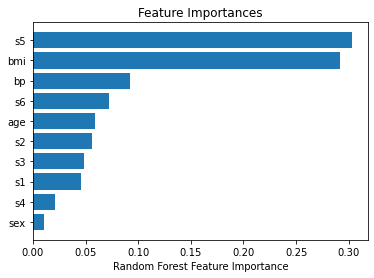

In [40]:
# FEATURE IMPORTANCE / FEATURE COEFFICIENTS - logistic regression/rf have coefficients built in or knowable

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor

# fetch a regression dataset
# in diabetes data we predict diabetes progression
# after one year based on some features
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# initialize the model
model = RandomForestRegressor()
model.fit(X,y)

#plot RF features
importances = model.feature_importances_
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

In [41]:
# FEATURE IMPORTANCE 2 : SelectFromModel (scikit)
#    this uses default params, but can set max_features or threshold value of feature importance

import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# fetch a regression dataset
# in diabetes data we predict diabetes progression
# after one year based on some features

data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# initialize the model
model = RandomForestRegressor()

# select from the model
sfm = SelectFromModel(estimator=model)
X_transformed = sfm.fit_transform(X,y)

#see which features were selected
support = sfm.get_support()

#get feature names
print([ x for x,y in zip(col_names,support) if y ==True])

['bmi', 'bp', 's5']


# Chapter 8: Hyperparameter Optimization

In [5]:
# grid search of best cominbation of parameters 
import numpy as np
import pandas as pd

from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection

df = pd.read_csv('mobile_train.csv')


#target is price range
y = df.price_range.values

X = df.drop('price_range',axis=1).values

#define model
classifier = ensemble.RandomForestClassifier(n_jobs=-1)

#grid params
param_grid = {
    'n_estimators': [100,200,250,300,400,500],
    'max_depth': [1,2,5,6,11,15],
    'criterion':['gini','entropy']
}

#init GridSearchCV()

model = model_selection.GridSearchCV(
    estimator= classifier,
    param_grid = param_grid,
    scoring= 'accuracy',
    verbose=10,
    n_jobs=-1,
    cv=5
)

model.fit(X,y)
print(f"Best score: {model.best_score_}")

print('best params set:')
best_params = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_params[param_name]}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1788s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0900s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   11.4s
[Parallel(n_j

Best score: 0.889
best params set:
	criterion: entropy
	max_depth: 15
	n_estimators: 500


In [10]:
# another option is to do random search instead of grid search
#  this is faster than grid search if the # of iterations are less
#   model_selection.RandomizedSearchCV()

# pipelines - help for best process and 'in-cv' transformations

# scikit optimization - help with hyperparam optimization a step further
#   hyperopt does the same thing but uses trees

# Chapter 9: Image Classification

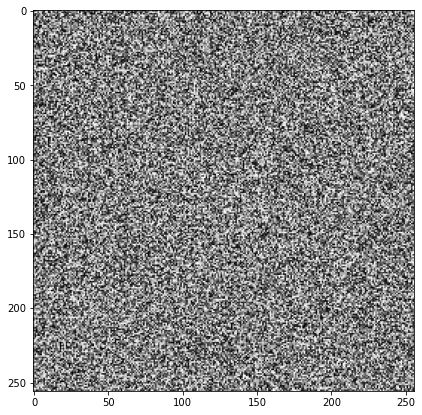

In [2]:
#pg 185

import numpy as np
import matplotlib.pyplot as plt

#generate random np array w values 0 to 255, and size of 256x256
random_image = np.random.randint(0,256,(256,256))

#init plot
plt.figure(figsize=(7,7))

#show grayscale img
plt.imshow(random_image,cmap='gray')
plt.show()

In [3]:
#one image can be represented by unravelling the matrix so we have 65k features in this one observation
random_image.ravel().shape

(65536,)

# Chapter 10: Approaching Text

In [5]:
# Splitting a string into a list of words = tokenization

from nltk.tokenize import word_tokenize

sentence = 'hi, how are you?'

sentence.split()

#using NTLK's word tokenize, the sentence is split in a better manner
word_tokenize(sentence)

['hi', ',', 'how', 'are', 'you', '?']

In [6]:
# Bag of Words = we create huge sparse matrix that stores counts of all words in our corpus
#  CountVectorizer from sklearn

from sklearn.feature_extraction.text import CountVectorizer

# create a corpus of sentences
corpus = [
 "hello, how are you?",
 "im getting bored at home. And you? What do you think?",
 "did you know about counts",
 "let's see if this works!",
 "YES!!!!"
]

ctv = CountVectorizer()

#fit on corpus
corpus_trans = ctv.fit_transform(corpus)

#each item corresponds to index 0 and each word gets assigned an index in index 1
#  words in range 0 - 22
print(corpus_trans)

  (0, 9)	1
  (0, 11)	1
  (0, 2)	1
  (0, 22)	1
  (1, 22)	2
  (1, 13)	1
  (1, 8)	1
  (1, 4)	1
  (1, 3)	1
  (1, 10)	1
  (1, 1)	1
  (1, 19)	1
  (1, 7)	1
  (1, 17)	1
  (2, 22)	1
  (2, 6)	1
  (2, 14)	1
  (2, 0)	1
  (2, 5)	1
  (3, 15)	1
  (3, 16)	1
  (3, 12)	1
  (3, 18)	1
  (3, 20)	1
  (4, 21)	1


In [14]:
# pg 230
#  incorporate word tokenize with countvectorizer

ctv = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)

corpus_trans = ctv.fit_transform(corpus)
print(ctv.vocabulary_)

{'hello': 14, ',': 2, 'how': 16, 'are': 7, 'you': 27, '?': 4, 'im': 18, 'getting': 13, 'bored': 9, 'at': 8, 'home': 15, '.': 3, 'and': 6, 'what': 24, 'do': 12, 'think': 22, 'did': 11, 'know': 19, 'about': 5, 'counts': 10, 'let': 20, "'s": 1, 'see': 21, 'if': 17, 'this': 23, 'works': 25, '!': 0, 'yes': 26}


In [4]:
# IMDB data set -- Create a sparse matrix by using all sentences
#   ratio of positive to negative examples is 1:1, thus we can use accuracy
#   which model? the one that is fastest for high dim, sparse data;
#     LOGISTIC REGRESSION
# this takes a long time to run----------------------------

import pandas as pd

from nltk.tokenize import word_tokenize
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('imdb.csv')
    
df.sentiment = df.sentiment.apply(lambda x: 1 if x =='positive' else 0)
df['kfold'] = -1
df = df.sample(frac=1).reset_index(drop=True)
y = df.sentiment.values
    
    #init kfold class
kf = model_selection.StratifiedKFold(n_splits=5)
    
    #fill the new kfold column
for f,(t,v) in enumerate(kf.split(X=df,y=y)):
    df.loc[v,'kfold'] = f
        
    #we iterate over folds
for fold_ in range(5):
        #temp dfs for train and test
    train_df = df[df.kfold != fold_].reset_index(drop=True)
    test_df = df[df.kfold == fold_].reset_index(drop=True)
        
        #count vec w NLTK word tokenizer
    count_vec = CountVectorizer(
        tokenizer = word_tokenize,
        token_pattern= None
        )
        
    count_vec.fit(train_df.review)
        
        #transform train and validation reviews
xtrain = count_vec.transform(train_df.review)
xtest = count_vec.transform(test_df.review)
        
model = linear_model.LogisticRegression()
        
model.fit(xtrain,train_df.sentiment)
        
preds = model.predict(xtest)
        
accuracy = metrics.accuracy_score(test_df.sentiment,preds)
        
print(f"Fold: {fold_}")
print(f"Accuracy = {accuracy}")
print("")

KeyboardInterrupt: 

In [2]:
#Naive Bayes is a popular algo for NLP tasks as it is efficient with sparse matricies, so much faster to train
# MultinomialNB from sklearn

import pandas as pd

from nltk.tokenize import word_tokenize
from sklearn import naive_bayes
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('imdb.csv')
    
df.sentiment = df.sentiment.apply(lambda x: 1 if x =='positive' else 0)
    
df['kfold'] = -1
    
df = df.sample(frac=1).reset_index(drop=True)
    
    #get target
y = df.sentiment.values
    
    #init kfold class
kf = model_selection.StratifiedKFold(n_splits=5)
    
    #fill the new kfold column
for f,(t,v) in enumerate(kf.split(X=df,y=y)):
    df.loc[v,'kfold'] = f
        
    #we iterate over folds
for fold_ in range(5):
        #temp dfs for train and test
    train_df = df[df.kfold != fold_].reset_index(drop=True)
    test_df = df[df.kfold == fold_].reset_index(drop=True)
        
        #count vec w NLTK word tokenizer
    count_vec = CountVectorizer(
        tokenizer = word_tokenize,
        token_pattern= None
        )
        
    count_vec.fit(train_df.review)
        
        #transform train and validation reviews
    xtrain = count_vec.transform(train_df.review)
    xtest = count_vec.transform(test_df.review)
        
    #MODEL CHANGE TO NAIVE BAYES-----------------    
    model = naive_bayes.MultinomialNB()
        
    model.fit(xtrain,train_df.sentiment)
            
    preds = model.predict(xtest)
        
    accuracy = metrics.accuracy_score(test_df.sentiment,preds)
        
    print(f"Fold: {fold_}")
    print(f"Accuracy = {accuracy}")
    print("")

Fold: 0
Accuracy = 0.8459

Fold: 1
Accuracy = 0.8423

Fold: 2
Accuracy = 0.8399

Fold: 3
Accuracy = 0.847

Fold: 4
Accuracy = 0.8479



### Term Frequencies / Document Frequencies

In [ ]:
#pg 234

#TF-IDF (AKA term frequencies-inverse docuemnt frequencies), TfidfVectorizer in sklearn

#TF(t) = # of times term t appears in document / total # of terms in document

#IDF(t) = LOG( N # of documents / # of documents with term t in it)

#TF-IDF(t) = TF(t) * IDF(t)

In [3]:
import pandas as pd

from nltk.tokenize import word_tokenize
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('imdb.csv')
    
df.sentiment = df.sentiment.apply(lambda x: 1 if x =='positive' else 0)
df['kfold'] = -1
df = df.sample(frac=1).reset_index(drop=True)
y = df.sentiment.values
    
    #init kfold class
kf = model_selection.StratifiedKFold(n_splits=5)
    
    #fill the new kfold column
for f,(t,v) in enumerate(kf.split(X=df,y=y)):
    df.loc[v,'kfold'] = f
        
    #we iterate over folds
for fold_ in range(5):
        #temp dfs for train and test
    train_df = df[df.kfold != fold_].reset_index(drop=True)
    test_df = df[df.kfold == fold_].reset_index(drop=True)
        
        #count vec w NLTK word tokenizer
    tfidf_vec = TfidfVectorizer(
        tokenizer = word_tokenize,
        token_pattern= None
        )
        
    tfidf_vec.fit(train_df.review)
        
        #transform train and validation reviews
    xtrain = tfidf_vec.transform(train_df.review)
    xtest = tfidf_vec.transform(test_df.review)
        
    model = linear_model.LogisticRegression()
        
    model.fit(xtrain,train_df.sentiment)
        
    preds = model.predict(xtest)
        
    accuracy = metrics.accuracy_score(test_df.sentiment,preds)
        
    print(f"Fold: {fold_}")
    print(f"Accuracy = {accuracy}")
    print("")

Fold: 0
Accuracy = 0.8988

Fold: 1
Accuracy = 0.8972

Fold: 2
Accuracy = 0.895

Fold: 3
Accuracy = 0.8927

Fold: 4
Accuracy = 0.8984



C:\Users\meich\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
#238 n grams

from nltk import ngrams
from nltk.tokenize import word_tokenize

#let's see 3 grams
N=3
sentence = 'hi, how are you?'

tokenized_sentence = word_tokenize(sentence)

#generate n-grams
n_grams = list(ngrams(tokenized_sentence,N))

In [5]:
n_grams

[('hi', ',', 'how'),
 (',', 'how', 'are'),
 ('how', 'are', 'you'),
 ('are', 'you', '?')]

In [6]:
## Change the model above to include ngram_range=(1,3) in tfidf_vec parameter

import pandas as pd

from nltk.tokenize import word_tokenize
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('imdb.csv')
    
df.sentiment = df.sentiment.apply(lambda x: 1 if x =='positive' else 0)
df['kfold'] = -1
df = df.sample(frac=1).reset_index(drop=True)
y = df.sentiment.values
    
    #init kfold class
kf = model_selection.StratifiedKFold(n_splits=5)
    
    #fill the new kfold column
for f,(t,v) in enumerate(kf.split(X=df,y=y)):
    df.loc[v,'kfold'] = f
        
    #we iterate over folds
for fold_ in range(5):
        #temp dfs for train and test
    train_df = df[df.kfold != fold_].reset_index(drop=True)
    test_df = df[df.kfold == fold_].reset_index(drop=True)
        
        #count vec w NLTK word tokenizer
    tfidf_vec = TfidfVectorizer(
        tokenizer = word_tokenize,
        token_pattern= None,
        ngram_range=(1,3)
        )
        
    tfidf_vec.fit(train_df.review)
        
        #transform train and validation reviews
    xtrain = tfidf_vec.transform(train_df.review)
    xtest = tfidf_vec.transform(test_df.review)
        
    model = linear_model.LogisticRegression()
        
    model.fit(xtrain,train_df.sentiment)
        
    preds = model.predict(xtest)
        
    accuracy = metrics.accuracy_score(test_df.sentiment,preds)
        
    print(f"Fold: {fold_}")
    print(f"Accuracy = {accuracy}")
    print("")

C:\Users\meich\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold: 0
Accuracy = 0.8913



C:\Users\meich\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold: 1
Accuracy = 0.8944



C:\Users\meich\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold: 2
Accuracy = 0.8939

Fold: 3
Accuracy = 0.8854

Fold: 4
Accuracy = 0.8946



### Stemming and Lemmatization

In [7]:
# Both techniques reduce a word to its smallest form.
# Stemming produces the stemmed word, lemmatization produces a lemma (lemmatization is more aggressive and less popular)

In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

#init lemmatizer
lemmatizer = WordNetLemmatizer()

#init stemmer
stemmer = SnowballStemmer('english')

words = ['grouping','groups','grouped','groupies']

for word in words:
    print(f"word={word}")
    print(f"stemmed_word={stemmer.stem(word)}")
    print(f"lemma={lemmatizer.lemmatize(word)}")
    print("")

word=grouping
stemmed_word=group
lemma=grouping

word=groups
stemmed_word=group
lemma=group

word=grouped
stemmed_word=group
lemma=grouped

word=groupies
stemmed_word=groupi
lemma=groupie



### Word Embeddings (deep learning)

In [11]:
# Approach is converting words into word vectors instead of integers for each word
# build a network that learns embeddings (vectors) for words. predict missing word by using all words around it, in terms of
#   vector distance. network will then learn and update embeddings for all words.
#  AKA Continuous Bag of Words (CBoW) model

In [2]:
# create a normalized word vector from all word vectors of tokens --> provides 'sentence vector'
#pg 246

import numpy as np

def sentence_to_vec(s, embedding_dict, stop_words, tokenizer):
    """
    Given a sentence and other info,
    return embedding for whole sentence
    param s = string
    param embedding_dict = {dictionary word: vector}
    param stop_words = list of stop words
    param tokenizer = tokenization fxn
    """
    
    #convert setence to string and lowecase it
    words  = str(s).lower()
    
    #tokenize sentence
    words = tokenizer(words)
    
    #remove stopwords
    words = [w for w in words if w not in stop_words]
    
    #keep only alpha-numeric tokens
    words = [w for w in words if w.isalpha()]
    
    #init empty list to store embeddings
    M = []
    for w in words:
        # for every word, fetch embedding from dict and append to list of embeddings
        
        if w in embedding_dict:
            M.append(embedding_dict[w])
    
    #if no vectors, return zeroes
    if len(M) == 0:
        return np.zeros(300)
    
    #convert list of embeddings to array
    M = np.array(M)
    
    #sum over each row
    v = M.sum(axis=0)
    
    #return normed vector
    return v / np.sqrt((v**2).sum())


### Temporal-based Text Classification 

In [4]:
# pg 250 --- create github for this one w/ project folder as talked about before

#create_folds.py ---------------------

import pandas as pd
from sklearn import model_selection

if __name__ == '__main__':
    
    #read training data
    df = pd.read_csv('imdb.csv')
    
    #map cat to binary
    df.sentiment = df.sentiment.apply(lambda x: 1 if x == 'positive' else 0)
    
    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    df = df.sample(frac=1).reset_index(drop=True)

    # fetch labels
    y = df.sentiment.values

    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=5)

    # fill the new kfold column
    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
        df.loc[v_, 'kfold'] = f

    # save the new csv with kfold column
    #df.to_csv("../input/imdb_folds.csv", index=False)

In [8]:
# now we create dataset.py, which includes a class which returns one sample of the training or validation data

# dataset.py----------------------------


import torch

class IMDBDataset:
    def __init__(self,reviews,targets):
        """
        reviews = numpy array
        targets = vector, np array
        """
        self.reviews = reviews
        self.targets = targets
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self,item):
        # for a given item, which is int, return review and targets as torch tensor. item is the index
        
        review = self.reviews[item, :]
        target = self.target[item]
        
        return {
            'review':torch.tensor(review,dtype=torch.long),
            'target':torch.tensor(target,dtype=torch.float)
        }

In [ ]:
# left off pg 252 -- lot of code deep into NLP/ pytorch tensors whiched seemed unnecessary for now

# Chapter 11: Approaching Ensembling and Stacking

In [9]:
#ensembling is just the act of combining your models, usually in terms of average prediction, or vote (if multiclass)
#  **it's much more effective to ensemble very different models than very similar models -- i.e. lower correlation w/
#       their predictions.

In [ ]:
#quick example
import numpy as np

def mean_prediction(probas):
    return np.mean(probas,axis=1)

def max_voting(preds)
    idxs = np.argmax(preds,axis=1)
    return np.take_along_axis(preds,idxs[:,None],axis=1)

#another unique example would be ranks of probabilities - i.e. AUC combination

def rank_mean(probas):
    
    ranked = []
    for i in range(probas.shape[1]):
        rank_data = stats.rankdata(probas[:,i])
        ranked.append(rank_data)
    ranked = np.column_stack(ranked)
    return np.mean(ranked,axis=1)

In [30]:
# important: create folds before optimizing weights of models to ensemble
#  -- this primarily applies to situations like AUC, where you NEED weights and can't just avg models or vote


import numpy as np
from functools import partial
from scipy.optimize import fmin
from sklearn import metrics

class OptimizeAUC:
    """
     Class for optimizing AUC.
     This class is all you need to find best weights for
     any model and for any metric and for any types of predictions.
     With very small changes, this class can be used for optimization of
     weights in ensemble models of _any_ type of predictions
     """
    def __init__(self):
        self.coef_ = 0
        
    def _auc(self,coef,X,y):
        """
        This functions calulates and returns AUC.
        :param coef: coef list, of the same length as number of models
        :param X: predictions, in this case a 2d array
        :param y: targets, in our case binary 1d array
        """
        
        #multiply coefficients w every column of array with predictions.
        #this means element 1 of coef is multiplied by col 1 of prediction array, elem 2 of coef is multiplied by column 2...etc
        x_coef = X * coef
        
        #create predictions by taking row wise sum
        predictions = np.sum(x_coef,axis=1)
        
        #claculate auc score
        auc_score = metrics.roc_auc_score(y,predictions)
        
        #return negative auc
        return -1 * auc_score
    
    def fit(self,X,y):
        
        #think this has something to do with passing on params to fmin optimize below
        loss_partial = partial(self._auc,X=X,y=y)
        
        # dirichlet distribution. you can use any distribution you want
        # to initialize the coefficients
        # we want the coefficients to sum to 1
        initial_coef = np.random.dirichlet(np.ones(X.shape[1]), size=1)
        
        # use scipy fmin to minimize the loss function, in our case auc
        self.coef_ = fmin(loss_partial, initial_coef, disp=True)
    
    def predict(self,X):
        
        # this is similar to _auc fxn
        x_coef = X * self.coef_
        predictions = np.sum(x_coef,axis=1)
        return predictions

In [31]:
#implementing optimizeAUC
# pg 277

import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
import numpy as np

#make binary classification dataset w 10k samples and 25 features
X,y = make_classification(n_samples=10000,n_features=25)

#split into two folds (just example, do more normally)
xfold1, xfold2, yfold1, yfold2 = model_selection.train_test_split(X,y,test_size=0.5,stratify=y)

#fit models on fold 1 and make predictions on fold 2
# we have 3 models:
# logistic regression, random forest and xgboost
logreg = linear_model.LogisticRegression()
rf = ensemble.RandomForestClassifier()
xgbc = xgb.XGBClassifier()

#fit all models on fold 1 data
logreg.fit(xfold1,yfold1)
rf.fit(xfold1, yfold1)
xgbc.fit(xfold1, yfold1)

#predict all models on fold 2
# take probability for class 1
pred_logreg = logreg.predict_proba(xfold2)[:, 1]
pred_rf = rf.predict_proba(xfold2)[:, 1]
pred_xgbc = xgbc.predict_proba(xfold2)[:, 1]

#create average of all predictions
avg_pred = (pred_logreg + pred_rf + pred_xgbc) /3

#a 2d array of all predictions
fold2_preds = np.column_stack((pred_logreg,pred_rf,pred_xgbc,avg_pred))

#store individual AUC values
aucs_fold2 = []
for i in range(fold2_preds.shape[1]):
    auc = metrics.roc_auc_score(yfold2,fold2_preds[:,i])
    aucs_fold2.append(auc)
    
    
#----------------now we repeat for other fold - NOT IDEAL -- if you ever have to repeat code, create a fxn--------------##
logreg = linear_model.LogisticRegression()
rf = ensemble.RandomForestClassifier()
xgbc = xgb.XGBClassifier()
logreg.fit(xfold2, yfold2)
rf.fit(xfold2, yfold2)
xgbc.fit(xfold2, yfold2)
pred_logreg = logreg.predict_proba(xfold1)[:, 1]
pred_rf = rf.predict_proba(xfold1)[:, 1]
pred_xgbc = xgbc.predict_proba(xfold1)[:, 1]
avg_pred = (pred_logreg + pred_rf + pred_xgbc) / 3

fold1_preds = np.column_stack((pred_logreg,pred_rf,pred_xgbc,avg_pred))

#store individual AUC values
aucs_fold1 = []
for i in range(fold1_preds.shape[1]):
    auc = metrics.roc_auc_score(yfold1,fold1_preds[:,i])
    aucs_fold1.append(auc)
    

# find optimal weights using the optimizer
opt = OptimizeAUC()
# dont forget to remove the average column
opt.fit(fold1_preds[:, :-1], yfold1)
opt_preds_fold2 = opt.predict(fold2_preds[:, :-1])
auc = metrics.roc_auc_score(yfold2, opt_preds_fold2)
print(f"Optimized AUC, Fold 2 = {auc}")
print(f"Coefficients = {opt.coef_}")

opt = OptimizeAUC()
opt.fit(fold2_preds[:, :-1], yfold2)
opt_preds_fold1 = opt.predict(fold1_preds[:, :-1])
auc = metrics.roc_auc_score(yfold1, opt_preds_fold1)
print(f"Optimized AUC, Fold 1 = {auc}")
print(f"Coefficients = {opt.coef_}")

C:\Users\meich\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:04:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\meich\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:04:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Optimization terminated successfully.
         Current function value: -0.988416
         Iterations: 47
         Function evaluations: 100
Optimized AUC, Fold 2 = 0.9908260741286874
Coefficients = [-0.00113085  0.23309621  0.3379401 ]
Optimization terminated successfully.
         Current function value: -0.990905
         Iterations: 43
         Function evaluations: 91
Optimized AUC, Fold 1 = 0.9884188725880785
Coefficients = [-0.05267343  0.78072774  0.87759062]


# Approaching reproducible code & model serving

In [33]:
# docker containers - considered small virtual machines to let code be reproduced on any computer

# for more on this, pg 283.
# for now, should get used to storing code on git, w proper documentation, and code segmenting